<a href="https://colab.research.google.com/github/dchriscothern/college-guard-tracking-sample/blob/main/college_guard_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📁 Please upload tracking_college_guard_sample.csv


Saving tracking_college_guard_sample.csv to tracking_college_guard_sample.csv

Loaded file: tracking_college_guard_sample.csv
   possession_id  frame  timestamp_ms  ball_x  ball_y  pg_x  pg_y  pg_vx  \
0           12.0  101.0           0.0    47.2    22.1  46.1  21.8    0.4   
1           12.0  102.0          40.0    47.5    22.3  46.4  22.1    0.6   
2           12.0  103.0          80.0    48.1    22.5  46.9  22.6    0.9   
3           12.0  104.0         120.0    49.0    22.9  47.8  23.5    1.2   
4           12.0  105.0         160.0    49.8    23.2  48.9  24.7    1.4   

   pg_vy  def_x  def_y  def_distance  pg_speed  advantage       action_tag  \
0    0.1   47.9   23.4           1.7      0.41        0.0  INIT_POSSESSION   
1    0.3   48.1   23.2           1.6      0.67        0.0          DRIBBLE   
2    0.6   48.4   23.1           1.3      1.08        0.0          DRIBBLE   
3    0.9   48.7   23.0           1.0      1.50        0.0        PNR_START   
4    1.3   49.5   23.6     

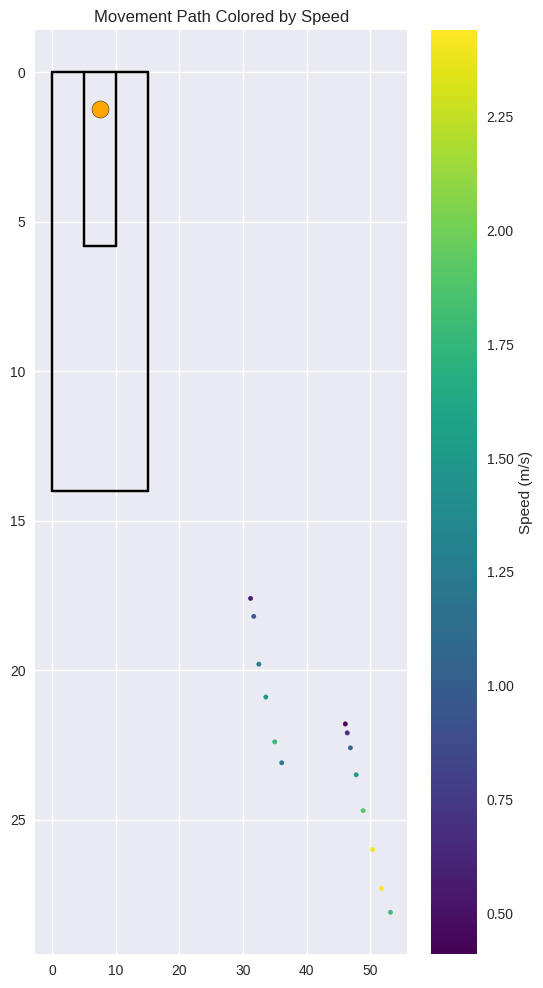

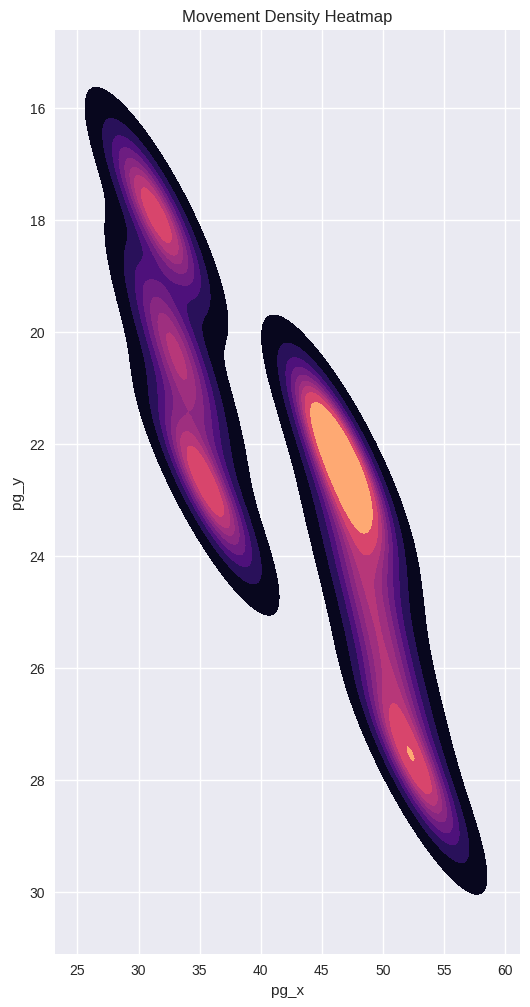

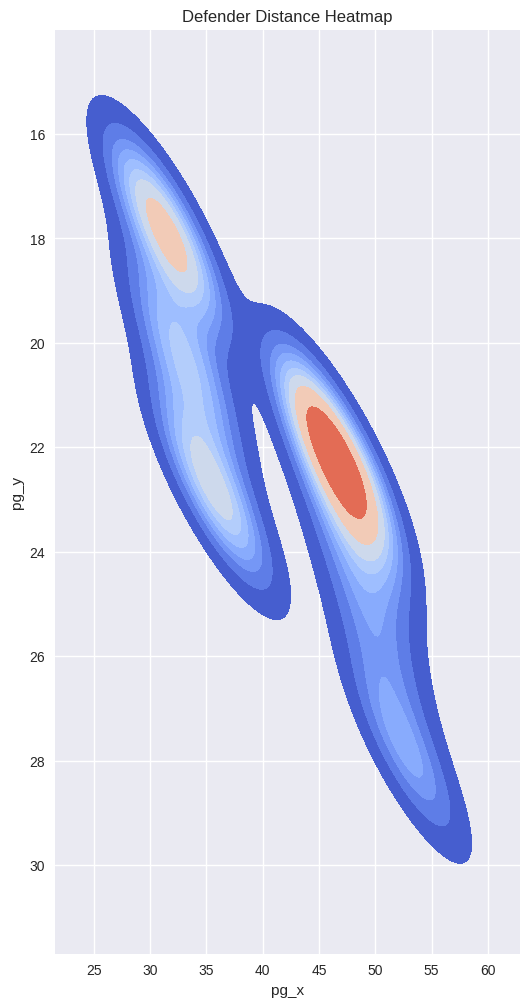

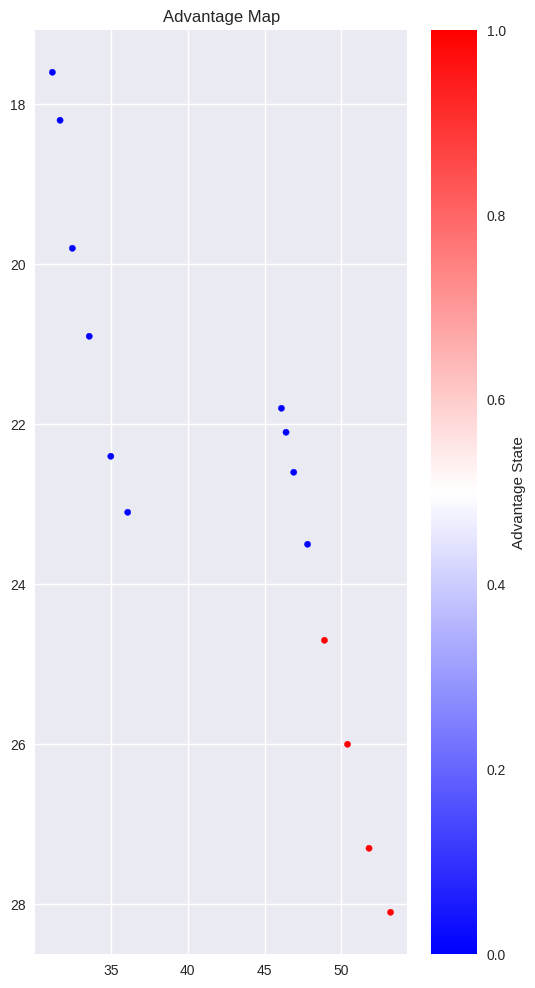

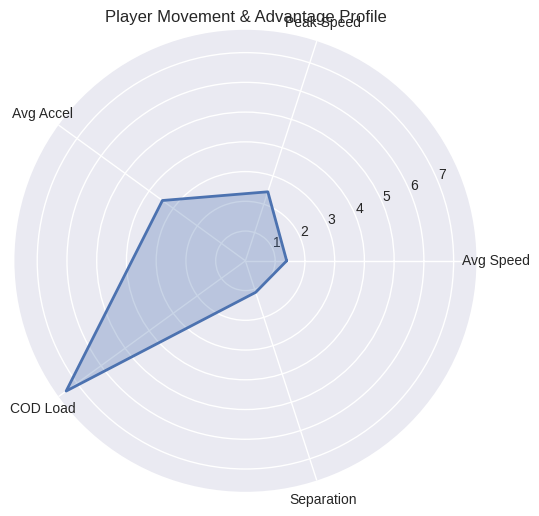


===== KEY INSIGHTS =====

Total distance traveled: 17.02 m
Peak speed: 2.44 m/s
Peak acceleration: 12.75 m/s²
Average defender distance: 1.11 m

Frames by advantage state:
advantage
0    11
1     4
Name: count, dtype: int64

High-speed efforts: 2

✔ All visuals generated successfully.


In [4]:
# ============================================================
# COLLEGE GUARD TRACKING ANALYSIS — PORTFOLIO VERSION
# Author: Chris Cothern, DPT, CSCS, CPSS
# Description:
#   Demonstration of applied basketball tracking analytics using Python.
#   Includes: scale detection, court drawing, derived metrics,
#   density heatmaps, defender context, radar chart, advantage map,
#   scouting-style visuals, and key insights.
# ============================================================

# ----------------------------
# 0. Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from math import pi

plt.style.use("seaborn-v0_8")

# ============================================================
# 1. DATA IMPORT
# ============================================================
print("📁 Please upload tracking_college_guard_sample.csv")

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\nLoaded file:", file_name)
print(df.head())


# ============================================================
# 2. AUTO-DETECT COURT SCALE
# ============================================================
def detect_court_scale(df, x_col="pg_x", y_col="pg_y"):
    x = pd.to_numeric(df[x_col], errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")

    x_span = x.max() - x.min()
    y_span = y.max() - y.min()

    # Heuristics:
    # Meters halfcourt ≈ 14–16 width × 15–18 length
    # Feet halfcourt ≈ 47 length × 50 width full court → half ~25 length
    if x_span > 25 or y_span > 25:
        unit = "feet"
    else:
        unit = "meters"

    return {
        "unit": unit,
        "x_min": float(x.min()),
        "x_max": float(x.max()),
        "y_min": float(y.min()),
        "y_max": float(y.max()),
        "x_span": float(x_span),
        "y_span": float(y_span)
    }

scale_info = detect_court_scale(df)
print("\n===== COURT SCALE DETECTED =====")
print(scale_info)


# ============================================================
# 3. DATA CLEANING & TIMESTAMPS
# ============================================================
numeric_cols = [
    "pg_x", "pg_y",
    "pg_vx", "pg_vy",
    "pg_speed",
    "advantage",
    "def_distance"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Create timestamp
if "timestamp_ms" in df.columns:
    df["timestamp_s"] = df["timestamp_ms"] / 1000.0
else:
    df["timestamp_s"] = np.arange(len(df)) * 0.04  # 25 fps fallback

df["advantage"] = df["advantage"].fillna(0).astype(int)


# ============================================================
# 4. DERIVED METRICS
# ============================================================
df["computed_speed"] = np.sqrt(df["pg_vx"]**2 + df["pg_vy"]**2)

df["pg_accel"] = df["pg_speed"].diff() / df["timestamp_s"].diff()
df["pg_accel"] = df["pg_accel"].replace([np.inf, -np.inf], np.nan).fillna(0)

df["cod_load"] = df["pg_accel"].abs()

df["dist_traveled"] = np.sqrt(df["pg_x"].diff()**2 + df["pg_y"].diff()**2).fillna(0)

speed_threshold = df["pg_speed"].mean() + df["pg_speed"].std()
df["high_speed_flag"] = df["pg_speed"] > speed_threshold

print("✔ Derived metrics computed.")


# ============================================================
# 5. POSSESSION SUMMARY TABLE
# ============================================================
summary = df.groupby("advantage").agg({
    "pg_speed": ["mean", "max"],
    "pg_accel": ["mean", "max"],
    "cod_load": "mean",
    "dist_traveled": "sum"
})

print("\n===== POSSESSION SUMMARY (by Advantage) =====\n")
print(summary)


# ============================================================
# 6. COURT DRAWING UTIL (ANNOTATED HALF COURT)
# ============================================================
def draw_halfcourt(ax, unit):
    """
    Minimalist NCAA/NBA-style halfcourt lines.
    Unit is auto-detected (meters or feet).
    """

    if unit == "feet":
        width = 50
        length = 47
        lane_w = 16
        lane_l = 19
        arc_r = 23.75
    else:  # meters
        width = 15
        length = 14
        lane_w = 4.9
        lane_l = 5.8
        arc_r = 6.75

    # Boundary
    ax.plot([0, width], [0, 0], color="black")
    ax.plot([0, width], [length, length], color="black")
    ax.plot([0, 0], [0, length], color="black")
    ax.plot([width, width], [0, length], color="black")

    # Lane
    ax.plot([(width-lane_w)/2, (width-lane_w)/2], [0, lane_l], color="black")
    ax.plot([(width+lane_w)/2, (width+lane_w)/2], [0, lane_l], color="black")
    ax.plot([(width-lane_w)/2, (width+lane_w)/2], [lane_l, lane_l], color="black")

    # Rim (center)
    ax.scatter(width/2, 4 if unit=="feet" else 1.22, s=150, color="orange", edgecolor="black")

    return ax


# ============================================================
# 7. VISUALIZATION 1 — Movement Path
# ============================================================
fig, ax = plt.subplots(figsize=(6,12))
draw_halfcourt(ax, scale_info["unit"])

p = ax.scatter(df["pg_x"], df["pg_y"], s=10, c=df["pg_speed"], cmap="viridis")
fig.colorbar(p, label="Speed (m/s)")
ax.invert_yaxis()
ax.set_title("Movement Path Colored by Speed")
plt.show()


# ============================================================
# 8 — Heatmaps
# ============================================================

# 8A: Movement Density
plt.figure(figsize=(6,12))
sns.kdeplot(x=df["pg_x"], y=df["pg_y"], cmap="magma", fill=True, bw_adjust=0.5, thresh=0.05)
plt.gca().invert_yaxis()
plt.title("Movement Density Heatmap")
plt.show()

# 8B: Defender Distance Heatmap
plt.figure(figsize=(6,12))
sns.kdeplot(
    x=df["pg_x"], y=df["pg_y"],
    weights=df["def_distance"],
    cmap="coolwarm", fill=True, bw_adjust=0.6, thresh=0.05
)
plt.gca().invert_yaxis()
plt.title("Defender Distance Heatmap")
plt.show()

# 8C: Advantage Map
plt.figure(figsize=(6,12))
plt.scatter(df["pg_x"], df["pg_y"], c=df["advantage"], cmap="bwr", s=20)
plt.gca().invert_yaxis()
plt.title("Advantage Map")
plt.colorbar(label="Advantage State")
plt.show()


# ============================================================
# 9 — Radar Chart Profile
# ============================================================
metrics = {
    "Avg Speed": df["pg_speed"].mean(),
    "Peak Speed": df["pg_speed"].max(),
    "Avg Accel": df["pg_accel"].mean(),
    "COD Load": df["cod_load"].mean(),
    "Separation": df["def_distance"].mean()
}

labels = list(metrics.keys())
values = list(metrics.values()) + [list(metrics.values())[0]]
angles = [n/float(len(labels)) * 2*pi for n in range(len(labels))] + [0]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.3)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Player Movement & Advantage Profile")
plt.show()


# ============================================================
# 10 — Key Insight Summary
# ============================================================
print("\n===== KEY INSIGHTS =====\n")
print(f"Total distance traveled: {df['dist_traveled'].sum():.2f} m")
print(f"Peak speed: {df['pg_speed'].max():.2f} m/s")
print(f"Peak acceleration: {df['pg_accel'].max():.2f} m/s²")
print(f"Average defender distance: {df['def_distance'].mean():.2f} m\n")
print("Frames by advantage state:")
print(df["advantage"].value_counts().sort_index())
print("\nHigh-speed efforts:", df["high_speed_flag"].sum())
print("\n✔ All visuals generated successfully.")
